In [8]:
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

# Set the directory where your PhysioNet data is stored
data_path = "data/training2017"

# Read the reference file (contains labels)
labels_df = pd.read_csv(f'{data_path}/REFERENCE.csv', header=None, names=['record_name', 'label'])


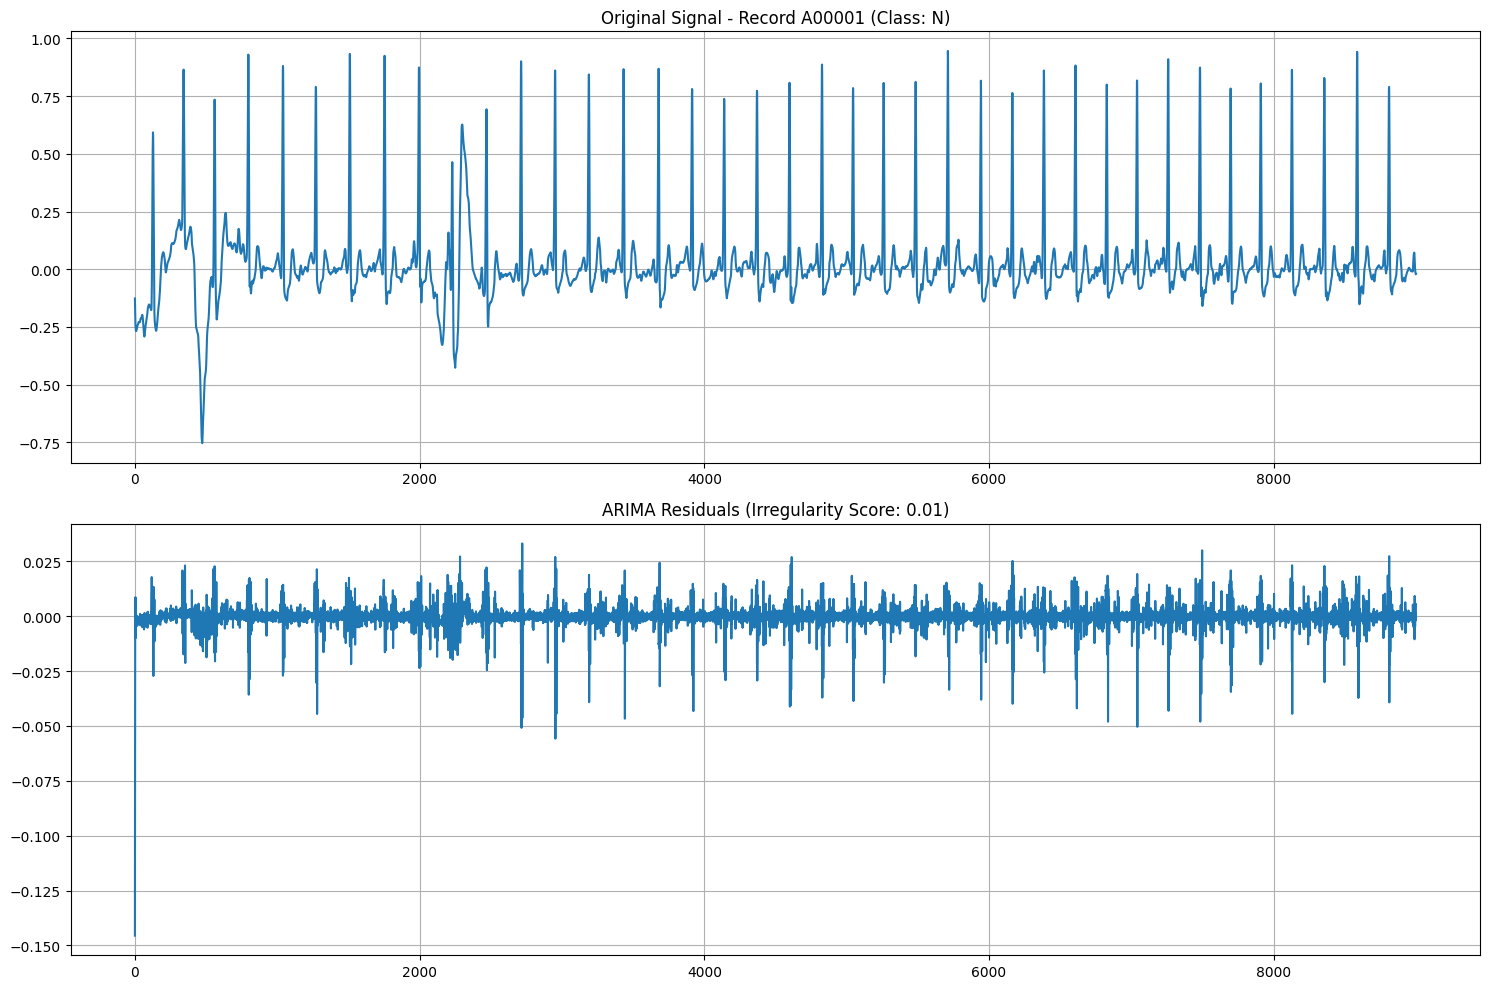

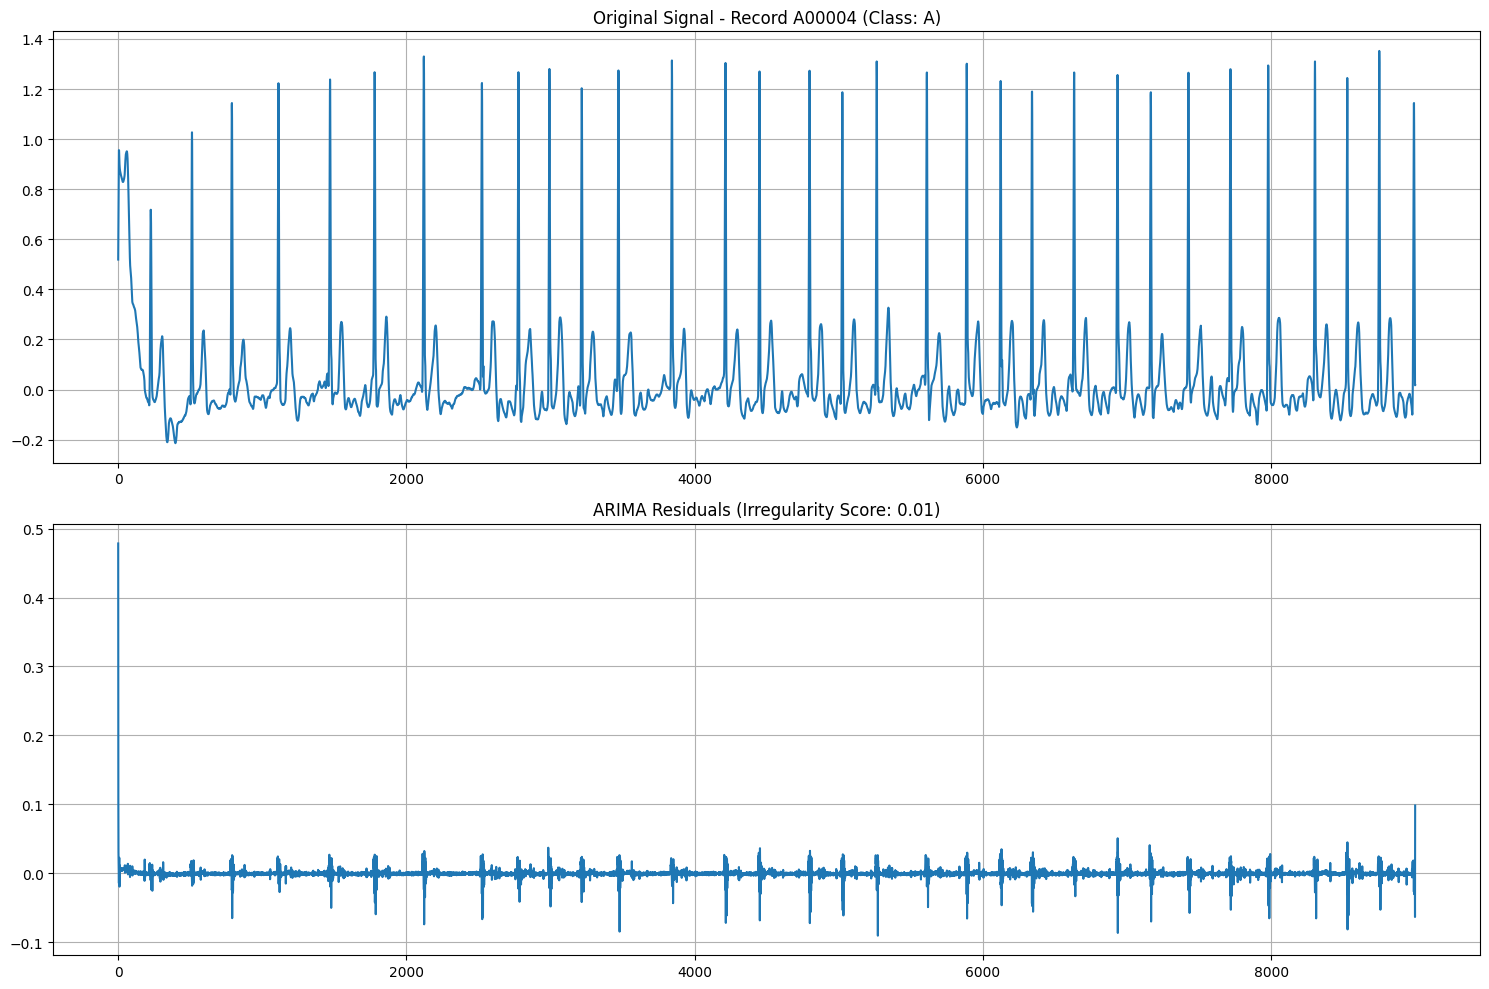

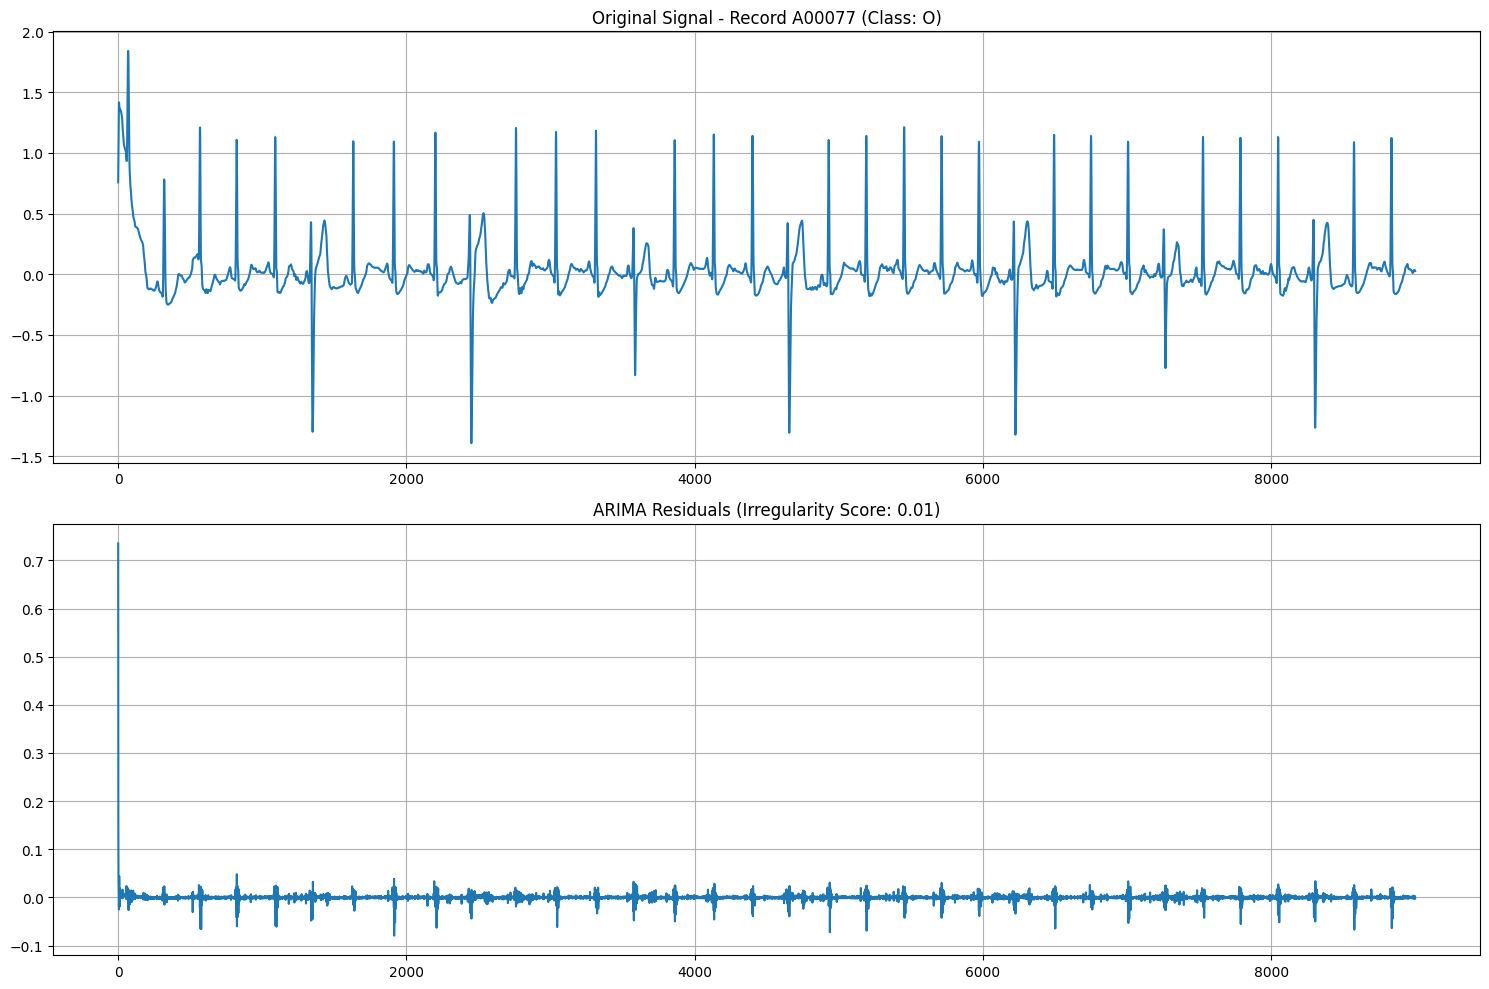

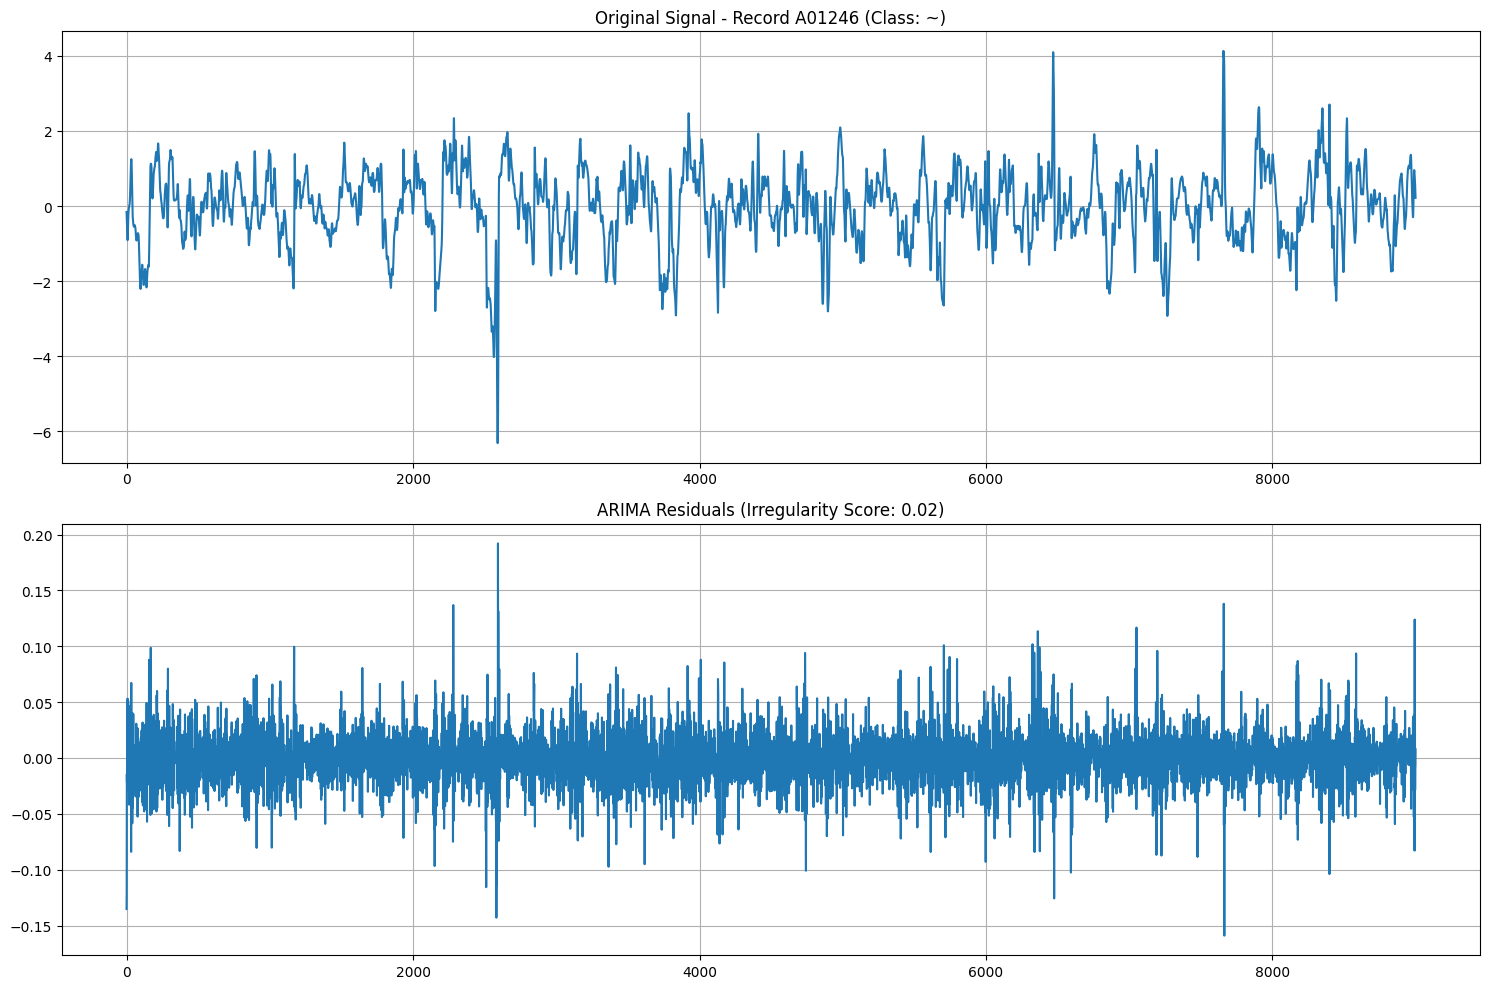


ARIMA Analysis Results:
  record_id label  irregularity_score  adf_statistic    adf_pvalue
0    A00001     N            0.005319     -16.330978  3.061166e-29
1    A00004     A            0.008464     -13.723021  1.178135e-25
2    A00077     O            0.010016     -13.238912  9.256520e-25
3    A01246     ~            0.021332      -9.582161  2.144073e-16


In [3]:
def analyze_arima(record_name, data_path, labels_df, plot=False):
    # Read the record
    record = wfdb.rdrecord(f'{data_path}/{record_name}')
    signals = record.p_signal.flatten()
    label = labels_df[labels_df.record_name == record_id].label.values[0]
    
    # Perform Augmented Dickey-Fuller test for stationarity
    adf_result = adfuller(signals)
    
    # Fit ARIMA model
    # Using order=(5,1,5) as an example - you might need to tune these parameters
    model = ARIMA(signals, order=(4, 0, 4))
    results = model.fit()
    
    # Get residuals (prediction errors)
    residuals = results.resid
    
    # Calculate irregularity metrics
    irregularity_score = np.std(residuals)

    if plot:
        # Plot original signal and residuals
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        ax1.plot(signals)
        ax1.set_title(f'Original Signal - Record {record_name} (Class: {label})')
        ax1.grid(True)
        
        ax2.plot(residuals) 
        ax2.set_title(f'ARIMA Residuals (Irregularity Score: {irregularity_score:.2f})')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'record_id': record_name,
        'label': label,
        'irregularity_score': irregularity_score,
        'adf_statistic': adf_result[0],
        'adf_pvalue': adf_result[1]
    }

# Test on a few records
record_ids = ['A00001', 'A00004', 'A00077', 'A01246']
arima_results = []

for record_id in record_ids:
    result = analyze_arima(record_id, data_path, labels_df, plot=True)
    arima_results.append(result)

# Display results
arima_results_df = pd.DataFrame(arima_results)
print("\nARIMA Analysis Results:")
print(arima_results_df)

In [23]:
def load_data(record_ids):
    data = []
    # load all the record_ids
    for record_id in record_ids:
        record = wfdb.rdrecord(f'{data_path}/{record_id}')
        signals = record.p_signal.flatten()
        label = labels_df[labels_df.record_name == record_id].label.values[0]
        data.append({
            'record_name': record_id,
            'signals': signals,
            'label': label
        })
    return pd.DataFrame(data)

record_ids = labels_df['record_name'].unique()
df = load_data(record_ids)
print(df.head())

  record_name                                            signals label
0      A00001  [-0.127, -0.162, -0.197, -0.229, -0.245, -0.25...     N
1      A00002  [0.128, 0.157, 0.189, 0.226, 0.25, 0.257, 0.26...     N
2      A00003  [0.056, 0.073, 0.085, 0.093, 0.1, 0.107, 0.113...     N
3      A00004  [0.519, 0.619, 0.723, 0.827, 0.914, 0.956, 0.9...     A
4      A00005  [-0.188, -0.239, -0.274, -0.316, -0.356, -0.37...     A


In [26]:
from sklearn.model_selection import train_test_split

# let's do an analysis to all records and see if there is any pattern across different labels.

X,y = df.drop('label', axis=1), df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200/len(X), random_state=42)

# lets run the ARIMA analysis on the test set
arima_results = []
for i, record_id in enumerate(X_test['record_name']):
    result = analyze_arima(record_id, data_path, labels_df)
    arima_results.append(result)

    # save the results to a csv file every 10 records
    if i % 10 == 0:
        pd.DataFrame(arima_results).to_csv(f'data/arima_results.csv', index=False)

# # Get all records
# record_ids = labels_df['record_name'].unique()
# arima_results = []

# for record_id in record_ids[100]:
#     result = analyze_arima(record_id, data_path, labels_df)
#     arima_results.append(result)
#     print(f"Processed {record_id}")

# # Display results
# arima_results_df = pd.DataFrame(arima_results)
# print("\nARIMA Analysis Results:")
# print(arima_results_df)

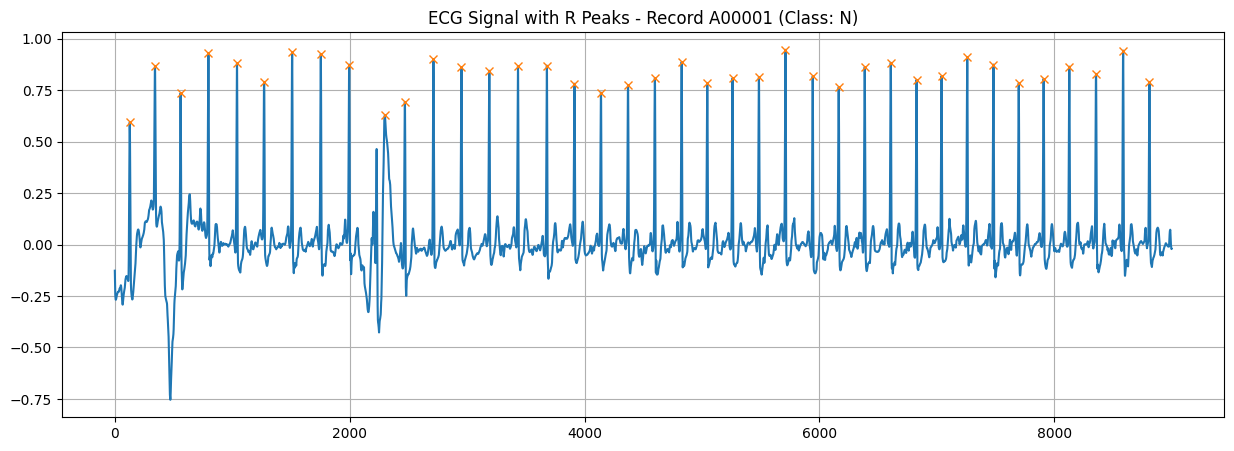

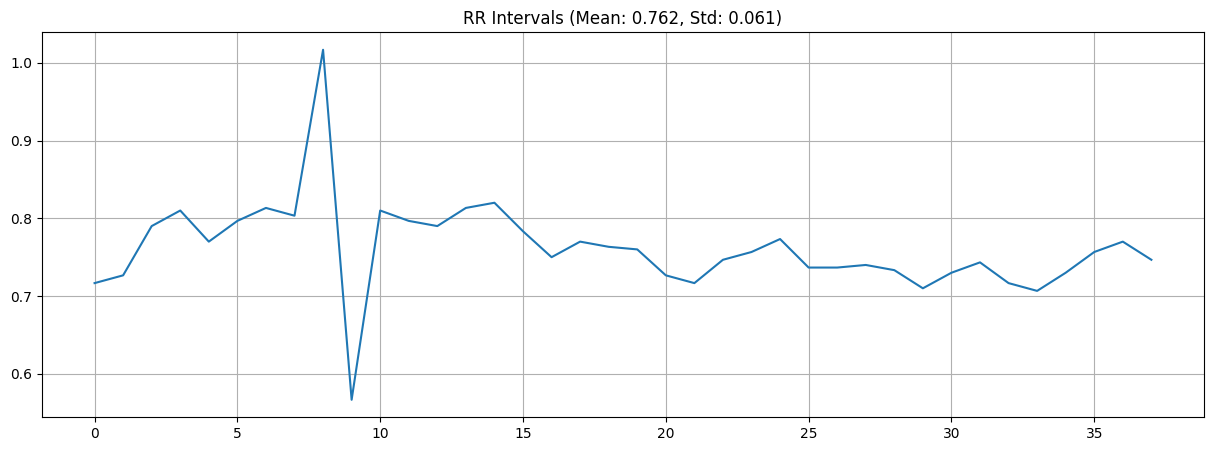

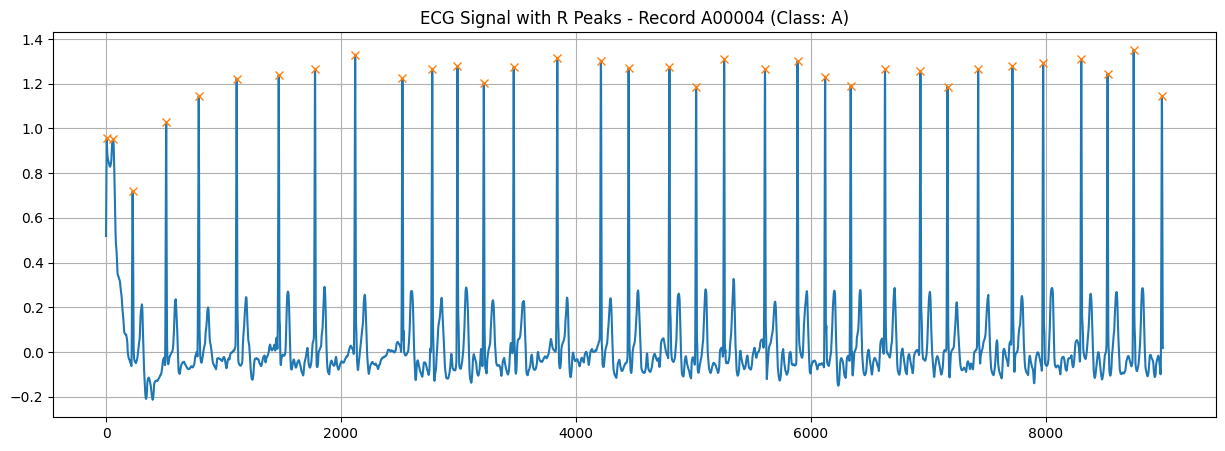

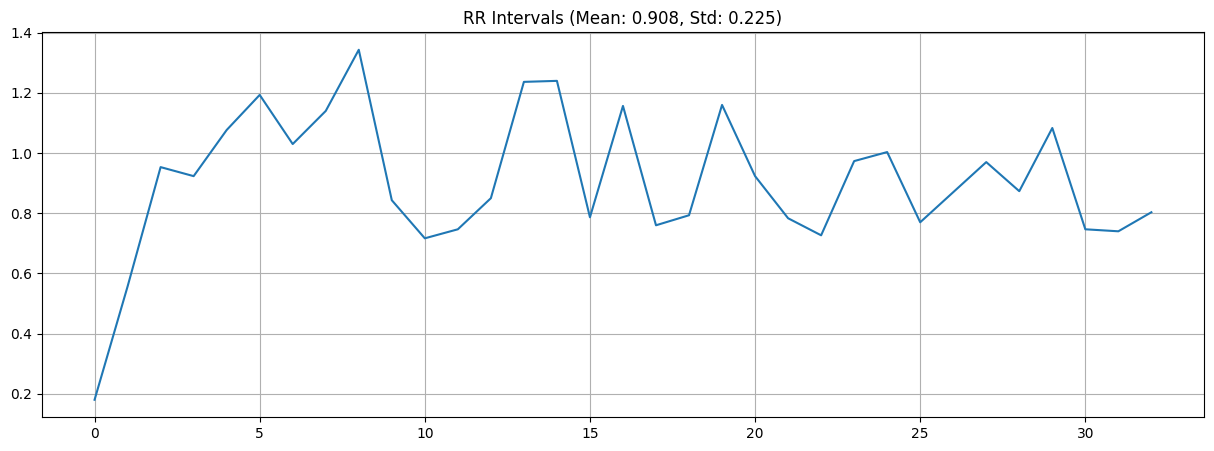

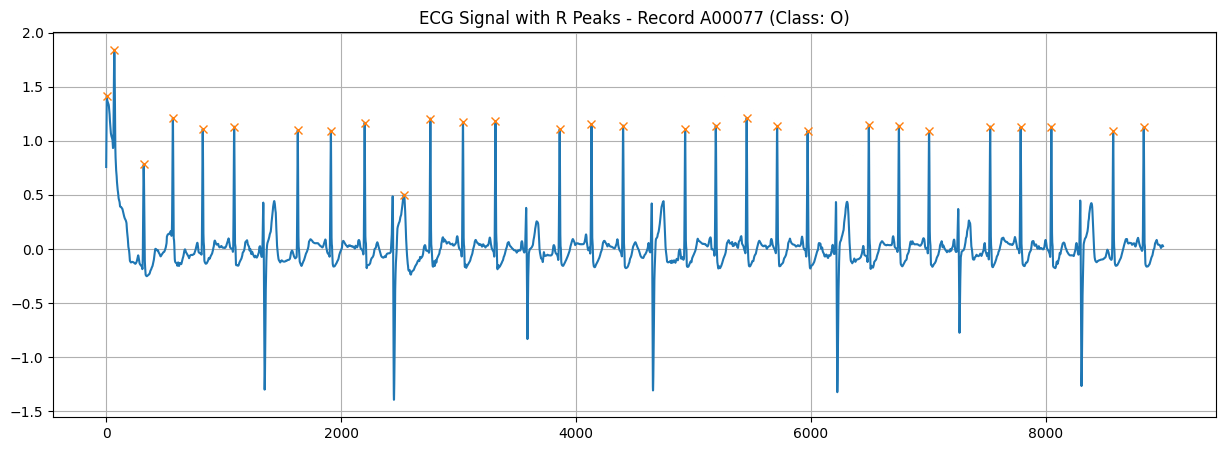

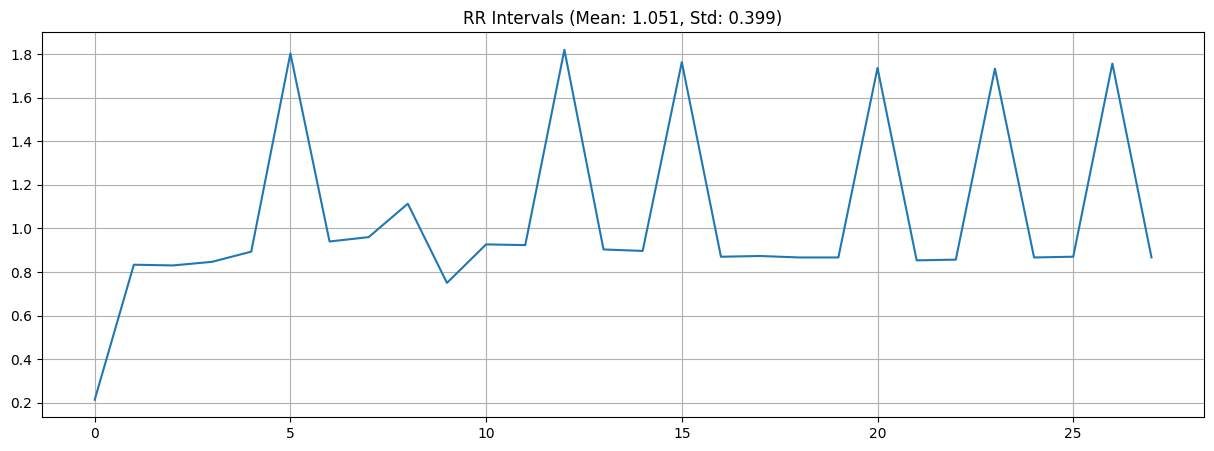

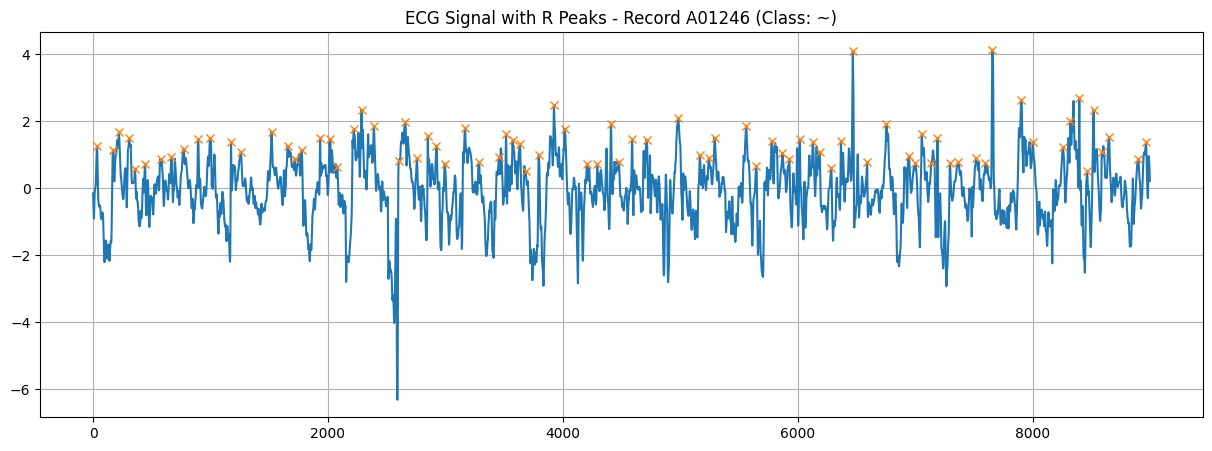

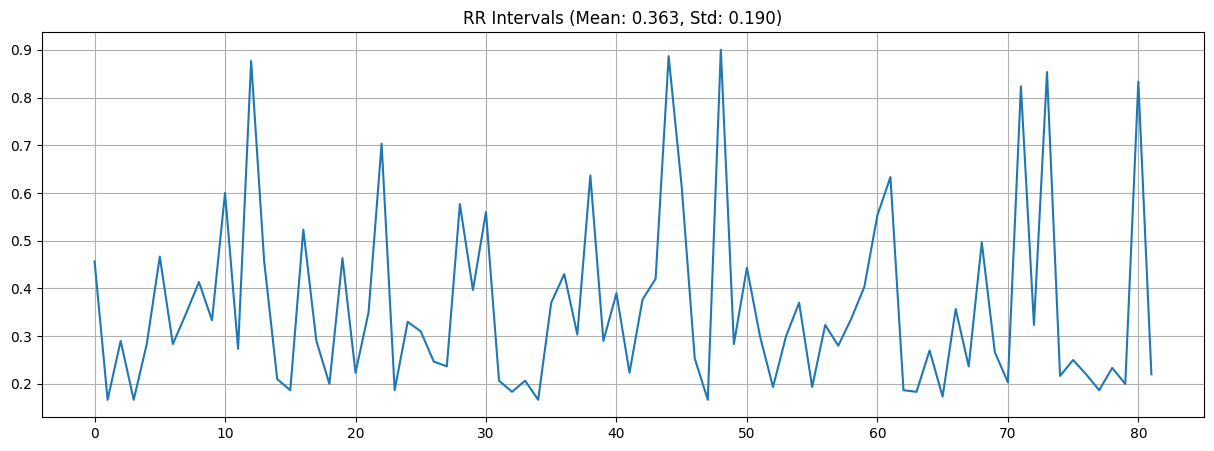


RR Interval Analysis Results:
  record_id label   mean_rr    std_rr     rmssd
0    A00001     N  0.761667  0.061300  0.093858
1    A00004     A  0.907677  0.225014  0.241459
2    A00077     O  1.051190  0.399343  0.607854
3    A01246     ~  0.363130  0.190321  0.280750


In [15]:
# let's compute for R-R interval
from scipy.signal import find_peaks

def compute_rr_intervals(signals, sampling_rate=300):
    # Find R peaks using scipy's find_peaks
    # Adjust height and distance parameters based on your signal characteristics
    r_peaks, _ = find_peaks(signals, height=0.5, distance=50)
    
    # Convert peak locations to time (in seconds)
    peak_times = r_peaks / sampling_rate
    
    # Calculate RR intervals (in seconds)
    rr_intervals = np.diff(peak_times)
    
    # Calculate common HRV metrics
    mean_rr = np.mean(rr_intervals)
    std_rr = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    
    return {
        'mean_rr': mean_rr,
        'std_rr': std_rr,
        'rmssd': rmssd,
        'rr_intervals': rr_intervals
    }

def analyze_rr_intervals(record_name, data_path, labels_df, plot=False):
    # Read the record
    record = wfdb.rdrecord(f'{data_path}/{record_name}')
    signals = record.p_signal.flatten()
    label = labels_df[labels_df.record_name == record_name].label.values[0]
    
    # Compute RR intervals and metrics
    rr_metrics = compute_rr_intervals(signals)
    
    if plot:
        # Plot original signal with R peaks
        plt.figure(figsize=(15, 5))
        plt.plot(signals)
        r_peaks, _ = find_peaks(signals, height=0.5, distance=50)
        plt.plot(r_peaks, signals[r_peaks], "x")
        plt.title(f'ECG Signal with R Peaks - Record {record_name} (Class: {label})')
        plt.grid(True)
        plt.show()
        
        # Plot RR intervals
        plt.figure(figsize=(15, 5))
        plt.plot(rr_metrics['rr_intervals'])
        plt.title(f'RR Intervals (Mean: {rr_metrics["mean_rr"]:.3f}, Std: {rr_metrics["std_rr"]:.3f})')
        plt.grid(True)
        plt.show()
    
    return {
        'record_id': record_name,
        'label': label,
        'mean_rr': rr_metrics['mean_rr'],
        'std_rr': rr_metrics['std_rr'],
        'rmssd': rr_metrics['rmssd']
    }

# Test on a few records
test_records = ['A00001', 'A00004', 'A00077', 'A01246']
results = []

for record_id in test_records:
    result = analyze_rr_intervals(record_id, data_path, labels_df, plot=True)
    results.append(result)

# Create DataFrame with results
results_df = pd.DataFrame(results)
print("\nRR Interval Analysis Results:")
print(results_df)

In [18]:
# process using R-R interval analysis the records from arima results
# load the arima results
arima_results = pd.read_csv('data/arima_results.csv')

rr_results = []
for i, record_id in enumerate(arima_results['record_id']):
    result = analyze_rr_intervals(record_id, data_path, labels_df)
    rr_results.append(result)

    # save the results to a csv file every 10 records
    if i % 10 == 0:
        pd.DataFrame(rr_results).to_csv(f'data/rr_results.csv', index=False)

# Create DataFrame with results
results_df = pd.DataFrame(results)
print("\nRR Interval Analysis Results:")
print(results_df)


RR Interval Analysis Results:
  record_id label   mean_rr    std_rr     rmssd
0    A00001     N  0.761667  0.061300  0.093858
1    A00004     A  0.907677  0.225014  0.241459
2    A00077     O  1.051190  0.399343  0.607854
3    A01246     ~  0.363130  0.190321  0.280750
